<a href="https://colab.research.google.com/github/k4zuy/Rep-Baal-Progress/blob/main/Augmented/baal_mean_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://github.com/ColinS97/BaaL_Experiments.git

In [2]:
#cd BaaL_Experiments

In [3]:
#!pip install baal

In [4]:
#!pip install pillow

Required for Nvidia RTX 3060

In [5]:
#python -m pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Required for Colab

In [6]:
!pip install matplotlib==3.1.3

/sw/installed/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sw/installed/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
ERROR: Will not install to the user site because it will lack sys.path precedence to matplotlib in /software/generic/JupyterHub/python-env-python3.8.6-20210715-1421/lib/python3.8/site-packages
You should consider upgrading via the '/software/generic/JupyterHub/python-env-python3.8.6-20210715-1421/bin/python3 -m pip install --upgrade pip' command.


Imports

In [7]:
import argparse
import random
import csv
from copy import deepcopy
from time import time
import datetime
from dataclasses import dataclass
import numpy as np
import PIL
import matplotlib.pyplot as plt

import torch
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision.models import vgg16
from torchvision.transforms import transforms
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal import ModelWrapper
from baal.utils.metrics import Accuracy
from baal.active.heuristics import BALD
from baal.active.dataset import ActiveLearningDataset

import aug_lib

from baal_extended.ExtendedActiveLearningDataset import ExtendedActiveLearningDataset

/lustre/scratch2/ws/1/keki996e-baal-working-nb/pyenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
@dataclass
class ExperimentConfig:
    epoch: int = 1
    batch_size: int = 32
    initial_pool: int = 10
    query_size: int = 100
    lr: float = 0.001
    heuristic: str = 'bald'
    iterations: int = 40
    training_duration: int = 10

In [9]:
def get_datasets(initial_pool, n_augmentations):
    transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    aug_transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            aug_lib.TrivialAugment(),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    test_transform = transforms.Compose(
        [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            #transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    # Note: We use the test set here as an example. You should make your own validation set.
    train_ds = datasets.CIFAR10(
        ".", train=True, transform=transform, target_transform=None, download=True
    )

    aug_train_ds = datasets.CIFAR10(
        ".", train=True, transform=aug_transform, target_transform=None, download=True
    )
    test_set = datasets.CIFAR10(
        ".", train=False, transform=test_transform, target_transform=None, download=True
    )
    eald_set = ExtendedActiveLearningDataset(train_ds)

    # active_set = ActiveLearningDataset(
    #    train_ds, pool_specifics={"transform": test_transform}
    # )
    eald_set.augment_n_times(n_augmentations, augmented_dataset=aug_train_ds)
    # We start labeling randomly.
    eald_set.label_randomly(initial_pool)
    return eald_set, test_set

In [10]:
hyperparams = ExperimentConfig()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

# Get datasets
active_set, test_set = get_datasets(hyperparams.initial_pool,2)

# Get our model.
heuristic = get_heuristic(hyperparams.heuristic)
criterion = CrossEntropyLoss()
model = vgg16(num_classes=10)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=0.9)

# Wraps the model into a usable API.
model = ModelWrapper(model, criterion)

# for ActiveLearningLoop we use a smaller batchsize
# since we will stack predictions to perform MCDropout.
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 hyperparams.query_size,
                                 batch_size=1,
                                 iterations=hyperparams.iterations,
                                 use_cuda=use_cuda,
                                 verbose=False)

# We will reset the weights at each active learning step so we make a copy.
init_weights = deepcopy(model.state_dict())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
original dataset length: 50000
augmented n times0


In [11]:
for epoch in tqdm(range(hyperparams.epoch)):
            # if we are in the last round we want to train for longer epochs to get a more comparable result
            #if epoch == args.epoch:
             #   hyperparams["learning_epoch"] = 75
            
            # Load the initial weights.
            
            model.load_state_dict(init_weights)
            model.train_on_dataset(
                active_set,
                optimizer,
                hyperparams.batch_size,
                hyperparams.training_duration,
                use_cuda,
            )

            # Validation!
            
            model.test_on_dataset(test_set, hyperparams.batch_size, use_cuda)
            metrics = model.metrics
            

  0%|          | 0/1 [00:00<?, ?it/s]

[139765-MainThread] [baal.modelwrapper:train_on_dataset:83] 2022-12-18T14:03:27.158476Z [info     ] Starting training              dataset=30 epoch=10


/lustre/scratch2/ws/1/keki996e-baal-working-nb/pyenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[139765-MainThread] [baal.modelwrapper:train_on_dataset:94] 2022-12-18T14:04:05.875192Z [info     ] Training complete              train_loss=2.2979798316955566
[139765-MainThread] [baal.modelwrapper:test_on_dataset:123] 2022-12-18T14:04:05.876415Z [info     ] Starting evaluating            dataset=10000
[139765-MainThread] [baal.modelwrapper:test_on_dataset:133] 2022-12-18T14:04:10.522281Z [info     ] Evaluation complete            test_loss=2.302666425704956


100%|██████████| 1/1 [00:43<00:00, 43.41s/it]


In [62]:
orgset_len = int(len(active_set._dataset)/(3)) # length of original dataset (dataset divided through amount augmentatios + 1)
print("orgset_len: " + str(orgset_len))
pool = active_set.pool
if len(pool) > 0:
    indices = np.arange(len(pool)) # array von 0 bis len(pool)-1 (nach initial label: 146999)
    #probs = model.predict_on_dataset(pool,batch_size=10,iterations=hyperparams.iterations,use_cuda=use_cuda)
    #if probs is not None and (isinstance(probs, types.GeneratorType) or len(probs) > 0):
    # -> "isinstance(...) needed when using predict_..._Generator"
    if probs is not None and len(probs) > 0:
        #to_label, uncertainties = heuristic.get_ranks(probs) 
        uncertainties = heuristic.get_uncertainties(probs)
            # to_label -> indices sortiert von größter zu niedrigster uncertainty
            # uncertainty -> alle uncertainties des pools in Reihenfolge wie pool vorliegt
            #to_label = indices[np.array(to_label)] # was hier passiert keine Ahnung aber to_label bleibt gleich also unnütze Zeile?
        # 1. get all original images from to_label(whole pool sorted after uncertainties highest to lowest)
        # 2. get for each original image the ids of augmented children and all three uncertainties
        # 3. calculate the means
        # 4. sort those means after highest to lowest uncertainties 
        # 5. label images (all of one kind) after query value with pool indices
        trios = []
        oracle_idx = active_set._pool_to_oracle_index(indices)
        for idx in oracle_idx:   
            # checks if img already in trios
            if idx not in trios:
                if idx >= orgset_len and idx < len(active_set._dataset)-orgset_len:
                    # img is first augmentation
                    org = idx - orgset_len
                    aug1 = idx
                    aug2 = idx + orgset_len
                elif idx >= len(active_set._dataset)-orgset_len:
                    # img is second augmentation
                    org = idx - 2*orgset_len
                    aug1 = idx - orgset_len
                    aug2 = idx
                else:
                    # img is original 
                    org = idx
                    aug1 = idx + orgset_len
                    aug2 = idx + 2*orgset_len
                #trio = (org, aug1, aug2)
                #trios.append(trio)
                trios.append(int(org))
                trios.append(int(aug1))
                trios.append(int(aug2))
            #else:
              #print(f"idx: {idx} is in trios with len: {len(trios)}")
        #print("trios: " + str(trios))
        #trios = (np.asarray(trios,"int")).tolist()
        trios_uncertainties = []
        pool_trios = active_set._oracle_to_pool_index(trios)
        for i in range(len(pool_trios)):
            # get the uncertainty of all images
            trios_uncertainties.append(uncertainties[pool_trios[i]])
        trios_mean = []
        k = trios_uncertainties[0]
        assert len(trios_uncertainties) % 3 == 0, "trios_mean should be a multiple of augmentations + 1"
        for i in range(1,len(trios_uncertainties)):
            if (i+1) % 3 != 0:
                k += trios_uncertainties[i]
            else:
                k += trios_uncertainties[i]
                mean = k/3
                trios_mean.append(mean)
                k = 0
        trios_idx_mean_sorted = np.argsort(trios_mean)[::-1]
        to_label = []
        for idx in trios_idx_mean_sorted:
            # org image will be chosen
            to_label.append(pool_trios[3*idx])
        # original and all augmentations will be labled

       # active_set.label(to_label[: hyperparams.query_size])
    else:
        print("break")
        #break
else: 
    print("break")
    #break

orgset_len: 50000


In [65]:
len(oracle_idx)

149964

In [63]:
len(trios)

149991

In [ ]:
for i in range(len(oracle_idx)):
  if i != oracle_idx[i]:
    print(i)
    break

In [ ]:
oracle_idx[3815:3825]

In [54]:
def my_show(imgs):
    rows = 9
    columns = 5
    fig = plt.figure(figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img) 
    plt.show()

In [ ]:
len(active_set)

In [ ]:
plt.imshow(active_set._dataset[3820][0].permute(1, 2, 0).numpy())

In [66]:
def real_label_to_oracle(indices):
    oracle_idx = []
    for i in range(len(indices)):
        oracle_idx.append(active_set._labelled_to_oracle_index(indices[i]))
    return oracle_idx

labeled_idx = np.arange(len(active_set))
print(labeled_idx)
oracle_idx2 = real_label_to_oracle(labeled_idx)
print(oracle_idx2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[1, 3, 4355, 8824, 9162, 11962, 13326, 24905, 32141, 42275, 44334, 49696, 50001, 50002, 54355, 58823, 59160, 61960, 63326, 74902, 82135, 92268, 94327, 99691, 100001, 100002, 104355, 108823, 109160, 111960, 113326, 124902, 132135, 142268, 144327, 149691]


In [67]:
for i in range(len(oracle_idx2)):
    for j in range(len(trios)):
        if oracle_idx2[i] == trios[j]:
            print(f"labeled img {i} in trios {j}!!!")

labeled img 1 in trios 149964!!!
labeled img 3 in trios 149967!!!
labeled img 4 in trios 149970!!!
labeled img 5 in trios 149973!!!
labeled img 7 in trios 149976!!!
labeled img 8 in trios 149979!!!
labeled img 9 in trios 149982!!!
labeled img 10 in trios 149985!!!
labeled img 11 in trios 149988!!!
labeled img 13 in trios 4!!!
labeled img 15 in trios 26461!!!
labeled img 16 in trios 27469!!!
labeled img 17 in trios 35866!!!
labeled img 19 in trios 74686!!!
labeled img 20 in trios 96382!!!
labeled img 21 in trios 126778!!!
labeled img 22 in trios 132952!!!
labeled img 23 in trios 149041!!!
labeled img 25 in trios 5!!!
labeled img 27 in trios 26462!!!
labeled img 28 in trios 27470!!!
labeled img 29 in trios 35867!!!
labeled img 31 in trios 74687!!!
labeled img 32 in trios 96383!!!
labeled img 33 in trios 126779!!!
labeled img 34 in trios 132953!!!
labeled img 35 in trios 149042!!!


In [68]:
print(trios[4])
print(trios[0:10])

50002
[0, 50000, 100000, 2, 50002, 100002, 4, 50004, 100004, 5]


In [31]:
for i in range(len(oracle_idx2)):
    for j in range(len(oracle_idx)):
        if oracle_idx2[i] == oracle_idx[j]:
            print(f"labeled img {i} in pool {j}!!!")

In [36]:
for i in range(len(oracle_idx)):
    if oracle_idx[i] == 58824:
        print(f"VORHANDEN bei {i}")
        
print("nicht vorhanden")

VORHANDEN bei 58812
nicht vorhanden


In [55]:
def plotable_array(arr):
    img_arr_labelled = []
    for i in range(len(arr)):
      img_arr_labelled.append(arr[i][0])
    return img_arr_labelled

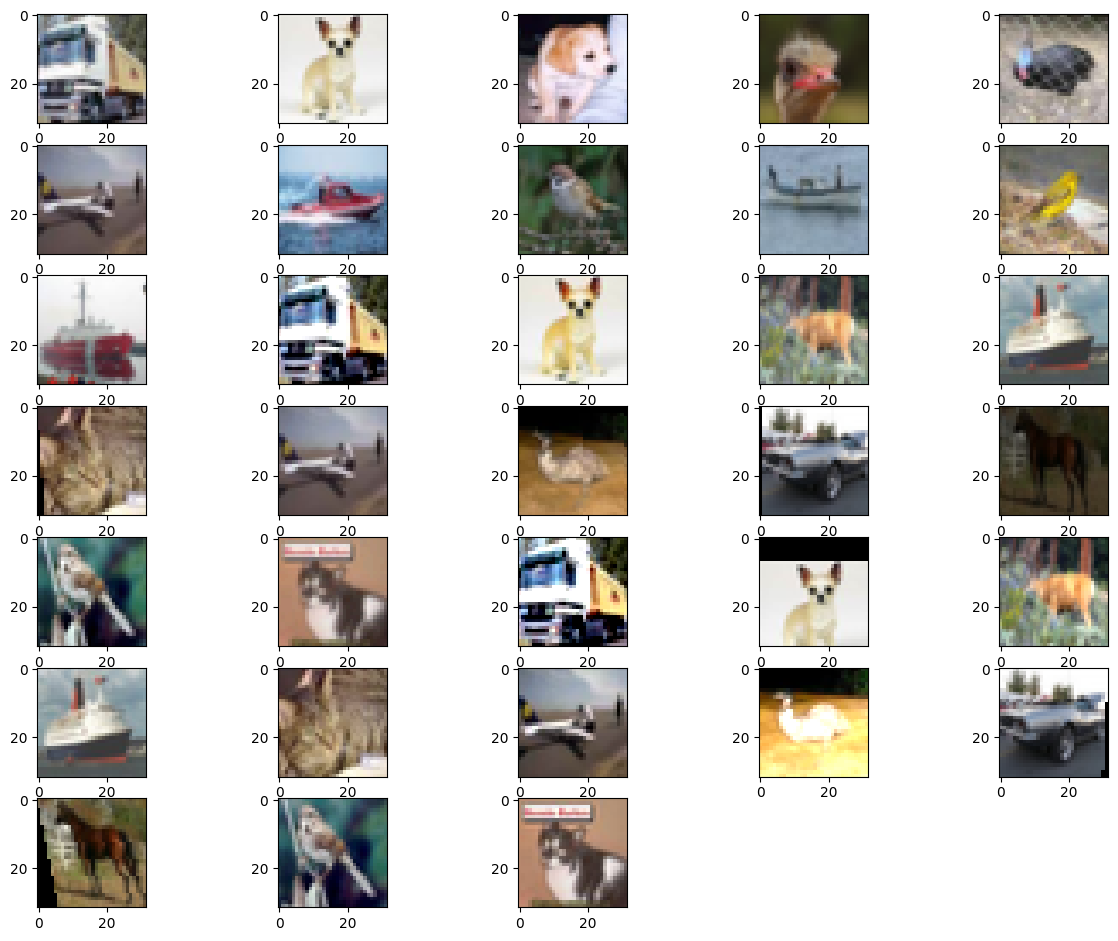

In [57]:
my_show(plotable_array(active_set))

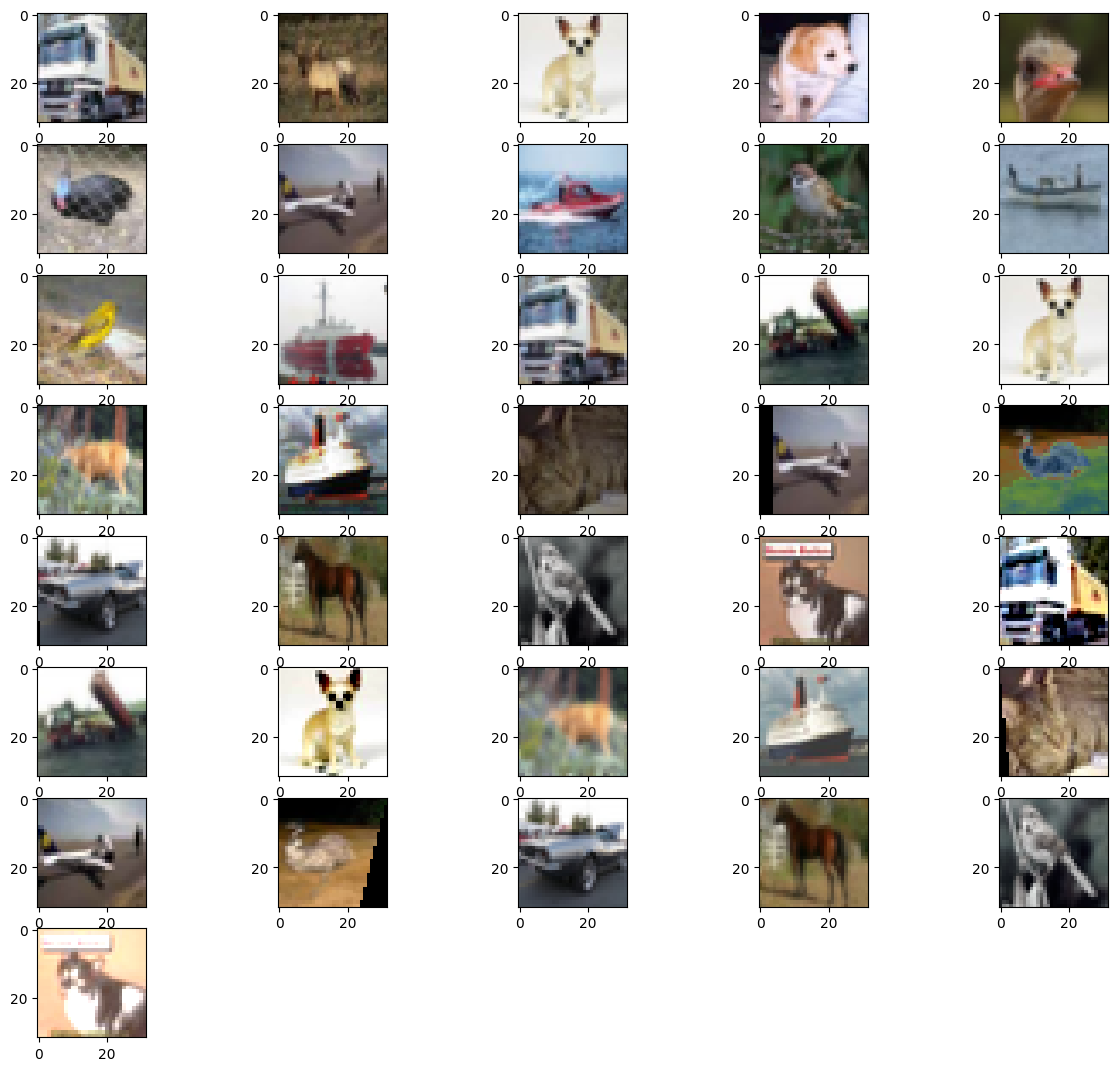

In [60]:
my_show(plotable_array(active_set))

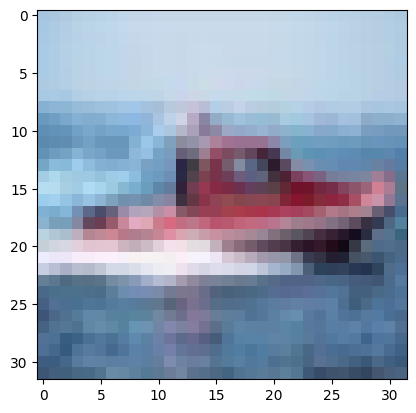

In [44]:
plt.imshow(active_set._dataset[24905][0].permute(1, 2, 0).numpy())

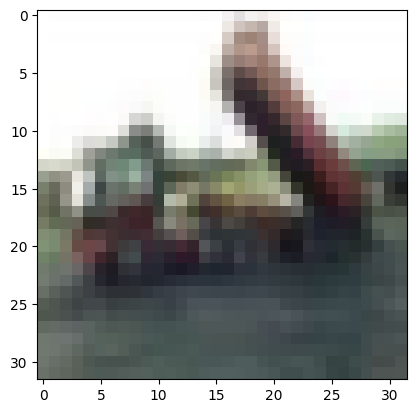

In [70]:
plt.imshow(active_set.pool[1][0].permute(1, 2, 0).numpy())

In [59]:
active_set.label(1)

In [49]:
len(active_set)

33

##Test std Serhiy

In [ ]:
# replacement for step
pool = active_set.pool
if len(pool) > 0:
    probs = model.predict_on_dataset(
        active_set._dataset,
        batch_size=hyperparams["batch_size"],
        iterations=hyperparams["iterations"],
        use_cuda=use_cuda,
    )

    #if probs is not None and (isinstance(probs, types.GeneratorType) or len(probs) > 0):
    # -> "isinstance(...) needed when using predict_..._Generator"
    if probs is not None and len(probs) > 0:
        # 1. Get uncertainty
        uncertainty = active_loop.heuristic.get_uncertainties(probs)
        oracle_indices = np.argsort(uncertainty)
        active_set.labelled_map

        pickle_dir_path, pickle_file_path = generate_pickle_file(dt_string, active_set, epoch, oracle_indices, uncertainty)

        mypickle = pd.read_pickle(pickle_file_path)

        uncertainty = mypickle['uncertainty']
        oracle_indices = mypickle['oracle_indices']
        labelled_map = mypickle['labelled_map']

        original = uncertainty[0:50000 - 1]
        aug1 = uncertainty[50000:100000 - 1]
        aug2 = uncertainty[100000:150000 - 1]

        if hyperparams["augment"] == 1:
            matrix = np.vstack([original, aug1])
        if hyperparams["augment"] == 2:   
            matrix = np.vstack([original, aug1, aug2])

        # 2. Calc standard deviation
        df_lab_img = pd.DataFrame(matrix)
        df_lab_img.std() # here
        df_lab_img = pd.DataFrame(np.vstack([matrix, df_lab_img.std()]))

        generate_excel_file(hyperparams["augment"], dt_string, active_set, epoch, pickle_dir_path, df_lab_img)
        
        # 3. Map std uncertainties to uncertainty array
        std_array = df_lab_img.std()
        for i in range(len(uncertainty)): # 150000
            uncertainty[i] = std_array[i % (50000-1)]
        oracle_indices = np.argsort(uncertainty)
        active_set.labelled_map
        # to_label -> indices sortiert von größter zu niedrigster uncertainty
        # uncertainty -> alle std uncertainties des pools
        to_label = heuristic.reorder_indices(uncertainty)
        to_label = oracle_indices[np.array(to_label)] # len(to_label) = 150000
        if len(to_label) > 0:
            active_set.label(to_label[: hyperparams.get("query_size", 1)])
        else: break
    else:
        break
else: 
    break

In [ ]:
max_mean_idx = trios_idx_mean_sorted[0]
max_mean_idx

In [ ]:
max_mean = trios_mean[max_mean_idx]
assert max_mean == max(trios_mean), "Error"
max_mean

In [ ]:
to_label[:10]

In [ ]:
org_img = trios_uncertainties[3*max_mean_idx]
aug1_img =  trios_uncertainties[(3*max_mean_idx)+1]
aug2_img =  trios_uncertainties[(3*max_mean_idx)+2]
org_img_idx = pool_trios[3*max_mean_idx]
aug1_img_idx =  pool_trios[(3*max_mean_idx)+1]
aug2_img_idx =  pool_trios[(3*max_mean_idx)+2]
print(f"idx: {org_img_idx}, {aug1_img_idx}, {aug2_img_idx}")
print(f"values: {org_img}, {aug1_img}, {aug2_img}")
man_mean = (org_img+aug1_img+aug2_img)/3
print(f"mean: {man_mean}")

In [ ]:
for i in range(len(oracle_idx)):
  if oracle_idx[i] != i:
    print(f"i: {i}, v: {oracle_idx[i]}")
    break

oracle_idx[50:60]

In [ ]:
len(oracle_idx)

In [ ]:
a = [4.9,7.0]
print(type(a))
b = (np.asarray(a,"int")).tolist()
b

In [ ]:
print(active_set.n_labelled)
print(active_set.n_unlabelled)

In [ ]:
pool = active_set.pool
indices = np.arange(len(pool))
indices

In [ ]:
probs = model.predict_on_dataset(pool,batch_size=10,iterations=20,use_cuda=use_cuda)

In [ ]:
to_label, uncertainty = heuristic.get_ranks(probs) 
to_label = indices[np.array(to_label)]

In [ ]:
print(uncertainty)
print(to_label)

In [ ]:
# größte uncertainty 
# (ix_global_img sowieso in to_label[0] aber for-Schleife für besseres Verständnis)
# also to_label[0] == uncertainty[ix_global_img]
u = 0
ix_pool_img = 0
for i in range(len(uncertainty)):
  if(uncertainty[i]>u): 
    u = uncertainty[i]
    ix_pool_img = i

print("größte uncertainty: " + str(u))
print("dazugehöriger Index: " + str(ix_pool_img))

In [ ]:
# größter index
l = 0
for i in range(len(to_label)):
  if(to_label[i]>l): l = to_label[i]

l

In [ ]:
oracle_set_one = active_set._pool_to_oracle_index([104559])
print(oracle_set_one)
oracle_set_two = active_set._pool_to_oracle_index(to_label)
print(oracle_set_two[0])
#ix_global_img = oracle_set[0]
#ix_global_img


In [ ]:
oracle_set = active_set._pool_to_oracle_index(to_label)
ix_global_img = oracle_set[5]
ix_pool_img = to_label[5]

In [ ]:
pool_img = active_set.pool[ix_pool_img]
global_img = active_set._dataset[ix_global_img]
#global_img = active_set._dataset[ix_global_img]

In [ ]:
print(pool_img)

In [ ]:
tensors_global = []
tensors_pool = []

for i in range(2):
  pool_img = active_set.pool[ix_pool_img]
  global_img = active_set._dataset[ix_global_img]
  tensors_pool.append(pool_img)
  tensors_global.append(global_img)


print(torch.eq(tensors_pool[0][0],tensors_pool[1][0]))
print(torch.eq(tensors_global[0][0],tensors_global[1][0]))

In [ ]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        #axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Bilder mit Normalisierung -> verzerrte Farben

In [ ]:
show((pool_img[0],global_img[0]))

In [ ]:
torch.eq(global_img[0],pool_img[0])

In [ ]:
compare = torch.eq(global_img[0],pool_img[0])

for i in range(0,2):
  for l in range(0,31):
    for k in range(0,31):
      if compare[i][l][k] == False:
        print(f"compare[{i}][{l}][{k}]")

In [ ]:
torch.abs(global_img[0] - pool_img[0])

Normalisierung umgekehrt

In [ ]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],std = [ 1., 1., 1. ]),
                               ])

In [ ]:
show((invTrans(pool_img[0]),invTrans(global_img[0])))

In [ ]:
plt.imshow(invTrans(pool_img[0]).permute(1, 2, 0).numpy())

In [ ]:
plt.imshow(invTrans(global_img[0]).permute(1, 2, 0).numpy())

In [ ]:
torch.eq(invTrans(pool_img[0]),invTrans(global_img[0]))

In [ ]:
torch.abs(invTrans(pool_img[0]) - invTrans(global_img[0]))

Versuche herauszufinden was folgende Zeile genau macht und wieso aber bisher erfolglos

In [ ]:
to_label_two = indices[np.array(to_label)]
to_label_two

In [ ]:
print(type(to_label))
print(type(to_label_two))
print(len(to_label))
print(len(to_label_two))

In [ ]:
indices[np.array(to_label)]

In [ ]:
t = np.array([3,7,1,4])
t